# Long Short-Term Memory

Entra uma sequência de inputs $\{x_1, x_2, ...\}$

As saídas são $\{h_1, h_2, ...\}$

Para gerar $h_t$, usa-se $x_t$ e $h_{t-1}$, com $h_0 = 0$ // até aqui é **Recurrent** Neural Network ou RNN

<div align="center">

![RNN comum](RNNcomum.jpg)

</div>

Além disso, o sistema possuirá memória $c_t$, e para controlarmos a memória faremos "três redes neurais extras", de forma que o LSTM, no final, são 4 em 1.

Quais três? 

- Uma que controle **quais** informações salvar na memória: $i_t$
- Uma que decide se/como usar a memória: $o_t$
- Por fim, uma que decide se apaga ou não a memória: $f_t$

Todas irão agir apenas sob a forma de "portas lógicas", sendo vetores em $(0,1)^n $ (para algum $n$) e fazendo produto elemento a elemento com outros vetores. Por isto foram denotados por $-_t$, que representa tal porta lógica no instante $t$.

Denotaremos o resultado da rede neural "original" (que não é nenhuma das três acima) por $\overline{c}_t$. Isto se deve ao fato de $\overline{c}_t$ sofrer alterações das outras três **após** o resultado desta rede neural, até que enfim obtemos $h_t$.

Especificamente:
$$ f_t = \sigma_g(W_fx_t + U_fh_{t-1} + b_f), \\ i_t = \sigma_g(W_ix_t + U_ih_{t-1} + b_i),
 \\ o_t = \sigma_g(W_ox_t + U_oh_{t-1} + b_o), \\ \overline{c}_t = \sigma_c(W_cx_t + U_ch_{t-1} + b_c),
 \\ c_t = f_t \odot c_{t-1} + i_t \odot \overline{c}_t, \\ h_t = o_t \odot \sigma_h(c_t),$$

onde $\sigma_g = \frac{1}{1+e^{-x}}$ é a sigmoid (portanto entre 0 e 1), $\sigma_c = \frac{e^x - e^{-x}}{e^x + e^{-x}}$ é a tangente hiperbólica, e $\sigma_h$ pode ser a tangente hiperbólica ou identidade. 

Existem algumas variações de LSTM, uma delas é "peephole", onde o output $h_t$ não é usado como em RNN's clássicas, normalmente substituído pela memória $c_t$.



## Imports

In [1]:
## resolver problema no caminho do maturin do pyo3, que faz a biblioteca em rust ser acessível em python
import sys, os
for cam in sys.path:
    if cam.find('LSTM') != -1:
        caminho = os.path.join(cam, 'rust_funcs', '.env', 'Lib', 'site-packages', 'rust_funcs')
        print(caminho)
        break
sys.path.append(caminho)
import rust_funcs
sys.path.remove(caminho)
del caminho

import numpy as np

c:\Users\brunO\AreadeTrabalho\Prog\Python\LSTM\rust_funcs\.env\Lib\site-packages\rust_funcs


In [2]:
def relu(x):
    return (x > 0)*x

def tanh(x):
    return np.tanh(x)

def sigmoid(x):
    return (tanh(x/2)+1)/2

def logloss(y, yhat):
    return rust_funcs.logloss(y, yhat)

def crossentropy(y,yhat):
    return rust_funcs.crossentropy(y,yhat)

def quaderror(x, y, f = None):
    if f:
        return np.dot(f(x) - y, f(x) - y)/(2*len(y))
    return rust_funcs.quaderror(x,y)

In [25]:
n = 3
y = (np.random.random(10**n-1)+0.5)//1
yhat = np.arange(10**(-n),1, 10**(-n))
# logloss(y,yhat)
y[0] = 0.1 + 0.1 + 0.1 + 0.1 + 0.1 + 0.1 + 0.1 + 0.1 + 0.1 + 0.1 
print(y[0])
logloss(y,yhat), crossentropy(y,yhat)

(1.016692902176809, 1.0236065706239048)

In [3]:
listum=[]
lisdois=[]
listres=[]
f1 = logloss
f2 = rust_funcs.logloss
f3 = rust_funcs.logloss

def test(n, f):
    y = (np.random.random(10**n-1)+0.5)//1
    yhat = np.arange(10**(-n),1, 10**(-n))
    print(f1(y, yhat), f2(y, yhat), f3(y, yhat))
    number = %timeit -o f(y, yhat)
    return number
    # %timeit rust_funcs.logloss(y, yhat)
    # %timeit rust_funcs.logloss_teste(y, yhat)
for n in range(1, 7):
    um = test(n, f1)
    dois = test(n, f2)
    tres = test(n, f3)
    listum.append(um)
    lisdois.append(dois)
    listres.append(tres)

listum_std = []
lisdois_std = []
listres_std = []
for i in range(len(listum)):
    listum_std.append(listum[i].stdev)
    lisdois_std.append(lisdois[i].stdev)
    listres_std.append(listres[i].stdev)
    listum[i] = listum[i].average 
    lisdois[i] = lisdois[i].average 
    listres[i] = listres[i].average 
   

0.8310672893984336 0.8310672893984336 0.8310672893984336
805 ns ± 134 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
0.989140845541852 0.989140845541852 0.989140845541852
665 ns ± 16.2 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
0.9702631747868078 0.9702631747868078 0.9702631747868078
661 ns ± 13.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
0.9165062846305772 0.9165062846305772 0.9165062846305772
1.64 µs ± 60.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
0.9669125403353788 0.9669125403353788 0.9669125403353788


C:\Users\brunO\AppData\Local\Temp\ipykernel_7920\3530399263.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axe.set_xticklabels(list(range(0,7)))


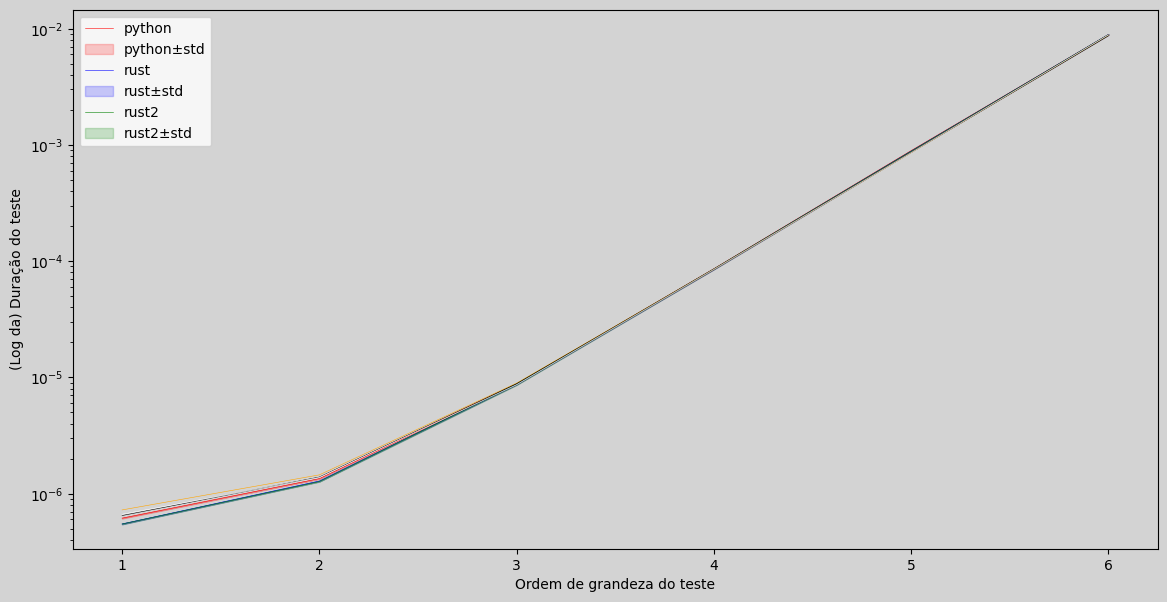

In [6]:
import seaborn as sns, matplotlib.pyplot as plt
fig, axe = plt.subplots(figsize=(14,7), facecolor='lightgray')
axe.set_facecolor('lightgray')
padrao = sns.lineplot(data=listum, ax=axe, color='red', linewidth=0.4)
meu_um = sns.lineplot(data=lisdois, ax=axe, color='blue', linewidth=0.4)
meu_dois = sns.lineplot(data=listres, ax=axe, color='green', linewidth=0.4)
k = 1
lower_bound = [M_new - k*Sigma for M_new, Sigma in zip(listum, listum_std)]
upper_bound = [M_new + k*Sigma for M_new, Sigma in zip(listum, listum_std)]
plt.fill_between(list(range(6)), lower_bound, upper_bound, alpha=.3, color='red')
lower_bound = [M_new - k*Sigma for M_new, Sigma in zip(lisdois, lisdois_std)]
upper_bound = [M_new + k*Sigma for M_new, Sigma in zip(lisdois, lisdois_std)]
plt.fill_between(list(range(6)), lower_bound, upper_bound, alpha=.3, color='blue')
lower_bound = [M_new - k*Sigma for M_new, Sigma in zip(listres, listres_std)]
upper_bound = [M_new + k*Sigma for M_new, Sigma in zip(listres, listres_std)]
plt.fill_between(list(range(6)), lower_bound, upper_bound, alpha=.3, color='green')
plt.yscale('log')
axe.legend(['python', 'python±std', 'rust', 'rust±std', 'rust2', 'rust2±std'])
axe.set_xlabel('Ordem de grandeza do teste')
axe.set_ylabel('(Log da) Duração do teste')
axe.set_xticklabels(list(range(0,7)))
plt.show()

C:\Users\brunO\AppData\Local\Temp\ipykernel_11156\2355496649.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axe.set_xticklabels(list(range(0,7)))


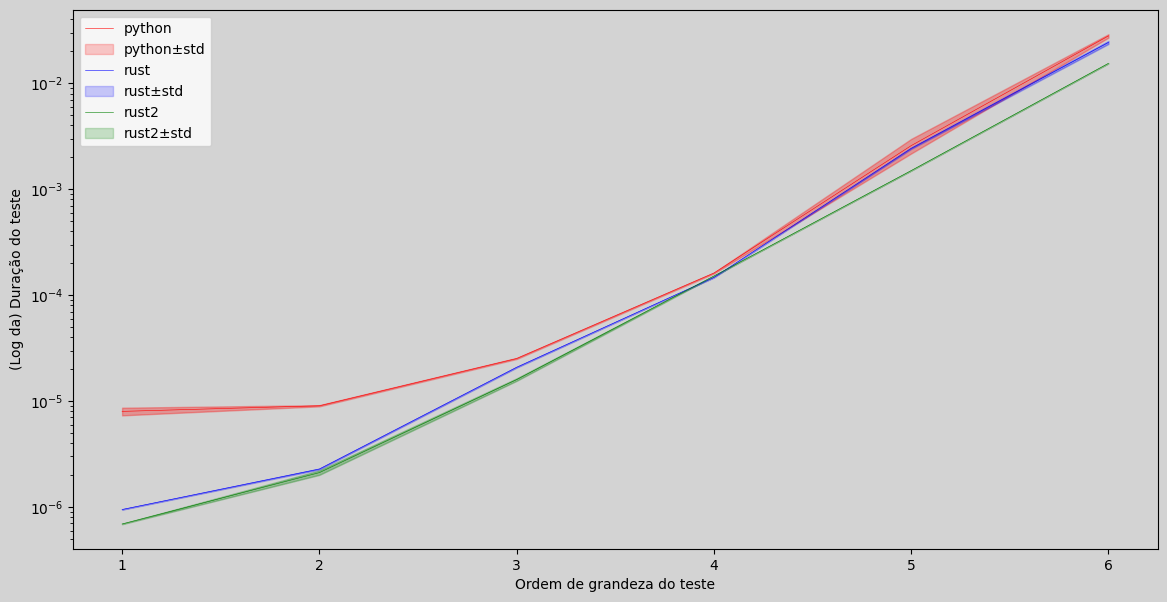

In [6]:


import seaborn as sns, matplotlib.pyplot as plt
fig, axe = plt.subplots(figsize=(14,7), facecolor='lightgray')
axe.set_facecolor('lightgray')
padrao = sns.lineplot(data=listum, ax=axe, color='red', linewidth=0.4)
meu_um = sns.lineplot(data=lisdois, ax=axe, color='blue', linewidth=0.4)
meu_dois = sns.lineplot(data=listres, ax=axe, color='green', linewidth=0.4)
k = 1
lower_bound = [M_new - k*Sigma for M_new, Sigma in zip(listum, listum_std)]
upper_bound = [M_new + k*Sigma for M_new, Sigma in zip(listum, listum_std)]
plt.fill_between(list(range(6)), lower_bound, upper_bound, alpha=.3, color='red')
lower_bound = [M_new - k*Sigma for M_new, Sigma in zip(lisdois, lisdois_std)]
upper_bound = [M_new + k*Sigma for M_new, Sigma in zip(lisdois, lisdois_std)]
plt.fill_between(list(range(6)), lower_bound, upper_bound, alpha=.3, color='blue')
lower_bound = [M_new - k*Sigma for M_new, Sigma in zip(listres, listres_std)]
upper_bound = [M_new + k*Sigma for M_new, Sigma in zip(listres, listres_std)]
plt.fill_between(list(range(6)), lower_bound, upper_bound, alpha=.3, color='green')
plt.yscale('log')
axe.legend(['python', 'python±std', 'rust', 'rust±std', 'rust2', 'rust2±std'])
axe.set_xlabel('Ordem de grandeza do teste')
axe.set_ylabel('(Log da) Duração do teste')
axe.set_xticklabels(list(range(0,7)))
plt.show()